This notebook implements the Transformer architecture from scratch using PyTorch, following the original "Attention Is All You Need" paper by Vaswani et al. The implementation avoids using high-level APIs (like `torch.nn.Transformer`) to give a deeper understanding of the model’s internal mechanics.

## Objectives
- Understand the architecture of the Transformer.
- Build each component from scratch:
  - Positional Encoding
  - Scaled Dot-Product Attention
  - Multi-Head Attention
  - Feedforward Networks
  - Encoder and Decoder Layers
  - Full Transformer Model
- Train the model on a toy dataset to demonstrate learning.



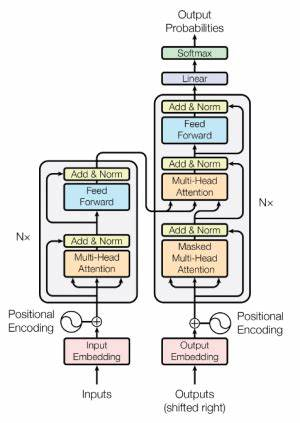

# Load dependencies

In [1]:
import requests
import re

# 1. Data Preparation
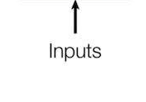

## 1.1. Load the data

In [2]:
# URL of the plain text file
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

In [3]:
response = requests.get(url)
text = response.text
text = text.lstrip('\ufeff')   # This will remove the Byte Order Mark (BOM) as "\ufeff"

print("The number of characters:",len(text))
print(text[:500])

The number of characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it'


## 1.2. Tokenize the data

In [4]:
class SimpleTokenizer:
  def __init__(self, text):

    tokens = self.__tokenize(text)
    all_words = sorted(set(tokens))

    # Adding Special Tokens
    # - <UNK> for handling unknown tokens -> Handling out-of-vocabulary words
    # - Begenning of sentence (BOS) -> Put in begenning of each document
    # - End Of Sentence (EOS) -> Put in end of each document
    # - Padding (BAD) -> Handling unequal sentences in length
    all_words.extend(('<UNK>','<BOS>','<EOS>','<PAD>'))

    self.voc_str_int = {word: i for i, word in enumerate(all_words)}
    self.voc_int_str = {i: word for i, word in enumerate(all_words)}

  def __tokenize(self, text):

    tokens = re.split(r'([,.?_!"()\':;]|--|\s)', text)

    tokens = [token.strip() for token in tokens if token.strip()]

    return tokens

  def encode(self, text):

    tokens = self.__tokenize(text)

    ids = [self.voc_str_int.get(token, self.voc_str_int['<UNK>']) for token in tokens]

    return ids

  def decode(self, ids):

    tokens = [self.voc_int_str.get(id, '<UNK>') for id in ids]

    text = ' '.join(tokens)

    text = re.sub(r'\s+([,.?_!"()\':;]|--|\s)', r'\1', text) # Remove spaces before this specified characters (eg. ,.?)

    return text

# 1.3. Create Data Loader

In [12]:
class SimpleDataLoader:
  def __init__(self, token_ids, context_size = 4, batch_size = 1, stride = 1):

    self.context_size = context_size
    self.batch_size = batch_size
    self.stride = stride

    self.X, self.Y = self.__create_dataset(token_ids)

  def __create_dataset(self, token_ids):

    X, Y = [], []

    for i in range(len(token_ids) - self.context_size - self.stride):

      X.append(token_ids[i : i + self.context_size])

      Y.append(token_ids[i + self.stride : i + self.context_size + 1])

    return X, Y

  def __len__(self):

    return len(self.X)

  def __getitem__(self, idx):

    return self.X[idx], self.Y[idx]

In [17]:
tokenizer = SimpleTokenizer(text)
token_ids = tokenizer.encode(text)

context_size = 10
dataloader = SimpleDataLoader(token_ids, context_size)

data_iter = iter(dataloader)

inputs, targets = next(data_iter)

print("Inputs:", inputs)
print("Targets:", targets)
# for x, y in next(data_iter):
#   print(f"{x} -> {y}")
#   print(tokenizer.decode(x), "->", tokenizer.decode(y), "\n")

# for i in range(5):
#   x, y = dataloader[i]
#   print(f"{x} -> {y}")
#   print(tokenizer.decode(x), "->", tokenizer.decode(y), "\n")

Inputs: [53, 44, 149, 1003, 57, 38, 818, 115, 256, 486]
Targets: [44, 149, 1003, 57, 38, 818, 115, 256, 486, 6]
